# SQUANCH demonstration: man-in-the-middle attack

In [1]:
from squanch import *
import numpy as np
import matplotlib.image as image
import matplotlib.pyplot as plt
%matplotlib inline

This Jupyter notebook contains the source code for the [man-in-the-middle attack demonstration](https://att-innovate.github.io/squanch/demos/man-in-the-middle.html). Refer to the documentation for more detailed explanations. 

This demonstration is a modified version of the [superdense coding demonstration](https://att-innovate.github.io/squanch/demos/superdense-coding.html). As before, Charlie will distribute Bell pairs to Alice and Bob, and Alice will attempt to send a classical message to Bob. However, a fourth party, Eve, will try to naiively intercept the message Alice sends to Bob. Eve will measure each qubit from Alice, record the result, and send the qubit to Bob. This scenario is illustrated below.

![](../docs/source/img/man-in-the-middle-small.png)

## Agent logic

In [2]:
class Charlie(Agent):
    '''Charlie distributes Bell pairs between Alice and Bob.'''
    def run(self):
        for qsys in self.stream:
            a, b = qsys.qubits
            H(a)
            CNOT(a, b)
            self.qsend(alice, a)
            self.qsend(bob, b)

In [3]:
class Alice(Agent):
    '''Alice sends information to Bob via superdense coding'''
    def run(self):
        for _ in self.stream:
            bit1 = self.data.pop(0)
            bit2 = self.data.pop(0)
            q = self.qrecv(charlie)
            if q is not None:
                if bit2 == 1: X(q)
                if bit1 == 1: Z(q)
            self.qsend(eve, q) # Alice unknowingly sends the qubit to Eve

In [4]:
class Bob(Agent):
    '''Bob receives Alice's transmissions and reconstructs her information'''
    def run(self):
        bits = []
        for _ in self.stream:
            a = self.qrecv(eve) # Bob receives his qubit from Eve
            c = self.qrecv(charlie)
            if a is not None and c is not None:
                CNOT(a, c)
                H(a)
                bits.extend([a.measure(), c.measure()])
            else:
                bits.extend([0,0])
        self.output(bits)

In [5]:
class Eve(Agent):
    '''Eve naively tries to intercept Alice's message'''
    def run(self):
        bits = [] 
        for _ in self.stream:
            a = self.qrecv(alice)
            if a is not None:
                bits.append(a.measure())
            else:
                bits.append(0)
            self.qsend(bob, a)
            self.increment_progress()
        self.output(bits)

In [6]:
# Some plotting and image processing functions

def image_to_black_and_white(filename):
    return np.around(np.mean(image.imread(filename), axis=2) / 255)
    
def plot_alice_bob_eve_images(eve_bits, bob_bits):
    eve_img = np.reshape(eve_bits, (int(img.shape[0]/2), img.shape[1]))
    bob_img = np.reshape(bob_bits, img.shape)
    f, ax = plt.subplots(1, 3, figsize = (18, 9))
    ax[0].imshow(-255*img, cmap = "Greys")
    ax[0].axis('off')
    ax[0].title.set_text("Alice's image")
    ax[1].imshow(-255*eve_img, cmap = "Greys")
    ax[1].axis('off')
    ax[1].title.set_text("Eve's image")
    ax[2].imshow(-255*bob_img, cmap = "Greys")
    ax[2].axis('off')
    ax[2].title.set_text("Bob's image")
    plt.tight_layout()
    plt.show()

In [7]:
# Load an image and serialize it to a bitstream
img = image_to_black_and_white("../docs/source/img/squanchLogo.jpg")
bitstream = list(img.flatten())

# Allocate a shared Hilbert space and output object to pass to agents
mem = Agent.shared_hilbert_space(2, int(len(bitstream) / 2))
out = Agent.shared_output()

# Make agent instances
alice = Alice(mem, out, data = bitstream)
bob = Bob(mem, out)
charlie = Charlie(mem, out)
eve = Eve(mem, out)

# Connect the agents over simulated fiber optic lines
alice.qconnect(bob, FiberOpticQChannel, length=1.0)
alice.qconnect(eve, FiberOpticQChannel, length=0.5)
alice.qconnect(charlie, FiberOpticQChannel, length=0.5)
bob.qconnect(charlie, FiberOpticQChannel, length=0.5)
bob.qconnect(eve, FiberOpticQChannel, length=0.5)

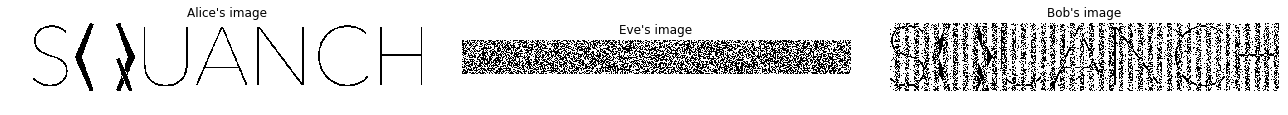

In [8]:
Simulation(alice, eve, bob, charlie).run()
plot_alice_bob_eve_images(out["Eve"], out["Bob"])